# Introduction
We analyse political data by examining the voting patterns of the 111th US House of Representatives during the years 2009-2011. We use the *rollcall-votes.Rdata* file, which records whether each of the 445 House members voted "yea" = 1, "nay" = -1, or abstained = 0 on 1,647 different legislative decisions. In addition, the file *rollcall-members.Rdata* enriches our dataset by providing additional details about the members, including their party affiliation (Republican or Democrat) and the US state they represent.

This tutorial promises to give you not only the technical skills to manipulate and analyse large datasets, but also insights into political dynamics and voting behaviour. By the end of this tutorial, you will have hands-on experience in data preparation, exploration and advanced analysis using unsupervised ML. nance.

## Load Data

This section of the script is dedicated to loading the essential datasets for our analysis. It retrieves the `rollcall-votes.Rdata` and `rollcall-members.Rdata` files from specified directories, effectively importing the voting records and member details of the 111th US House of Representatives. Upon successful loading, a confirmation message, "Data loaded," is printed to signal that the datasets are ready for use.

In [1]:
########################  Load Data  ########################

### Load data
load("/home/jupyter-mlcourseuser/M02-Machine-Learning/self_study_tutorial/scripts_and_data/rollcall-votes.Rdata")
load("/home/jupyter-mlcourseuser/M02-Machine-Learning/self_study_tutorial/scripts_and_data/rollcall-members.Rdata")
print('Data loaded.')

##############################################################

[1] "Data loaded."


In [2]:
head(members)

,member,state,party
,<fct>,<fct>,<fct>
1,BONNER (R AL-1),AL,R
2,BRIGHT (D AL-2),AL,D
3,ROGERS (R AL-3),AL,R
4,ADERHOLT (R AL-4),AL,R
5,GRIFFITH (D/R AL-5),AL,DR
6,BACHUS (R AL-6),AL,R


In [3]:
head(votes)

,Vote.1,Vote.2,Vote.3,Vote.4,Vote.5,Vote.6,Vote.7,Vote.8,Vote.9,Vote.10,⋯,Vote.1638,Vote.1639,Vote.1640,Vote.1641,Vote.1642,Vote.1643,Vote.1644,Vote.1645,Vote.1646,Vote.1647
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BONNER (R AL-1),-1,1,-1,0,0,1,-1,-1,1,1,⋯,-1,0,-1,-1,-1,-1,0,1,1,0
BRIGHT (D AL-2),1,-1,1,1,1,1,-1,-1,1,1,⋯,1,1,0,0,0,0,0,0,0,0
ROGERS (R AL-3),-1,1,-1,-1,-1,1,-1,-1,1,1,⋯,-1,-1,-1,-1,-1,1,-1,-1,1,1
ADERHOLT (R AL-4),-1,1,-1,-1,1,1,-1,-1,1,1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,1,1
GRIFFITH (D/R AL-5),1,-1,1,1,1,-1,-1,-1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
BACHUS (R AL-6),-1,1,-1,1,1,1,-1,0,1,1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


# Data Exploration

This section focuses on analyzing party composition and voting behaviors in the 111th US House of Representatives. We start by displaying counts and proportions of Democrats, Republicans, and one notable politician. Next, we examine voting participation by counting missing votes and visualizing this data with a histogram to analyze absenteeism patterns. Additionally, we count 'yea' and 'nay' votes, plotting these against each other by party to highlight differences in voting behavior across party lines. This exploration helps us understand the dataset's structure and the political dynamics at play.

**a) How many Democrats and Republicans are in the House? Who has the majority? Report the special case Democrat-Republican separately.**

In [4]:
print('# Counts of Democrats, Republicans and one special politician')
table(members$party)

print('# Shares of Democrats, Republicans and one special politician')
round(table(members$party)/nrow(members),3)

[1] "# Counts of Democrats, Republicans and one special politician"



  D  DR   R 
262   1 182 

[1] "# Shares of Democrats, Republicans and one special politician"



    D    DR     R 
0.589 0.002 0.409 

In [5]:
members[members$party == "DR",]

,member,state,party
,<fct>,<fct>,<fct>
5,GRIFFITH (D/R AL-5),AL,DR


**b) Generate a variable for the number of votes each politician missed. How many politicians voted in all votings? Plot a histogram of the shares of missed votings with 100 bins.**

In [6]:
# Count missing votings for each politician and plot the counts
missings <- rowSums(votes==0)

# No. politicians who always voted
sum(missings == 0)

[1] 3

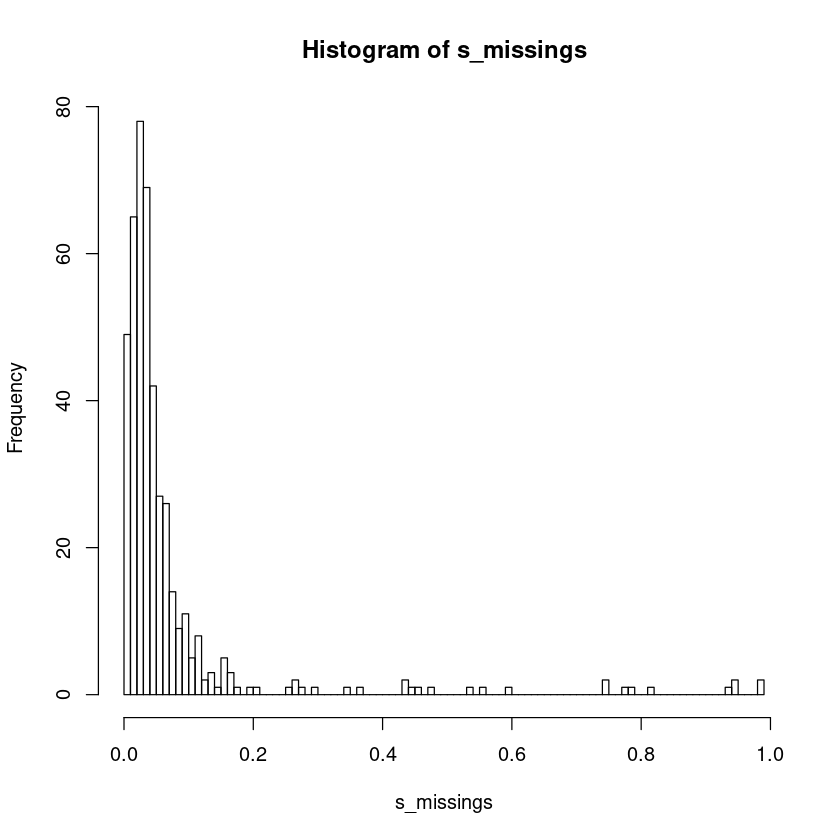

In [7]:
# Shares of missing votings
s_missings <- missings/(ncol(votes))

# Histogram with 100 bins
hist(s_missings, breaks = 100)

**c) Generate variables for the number of times each politician voted “yea” and “nea”. Make a scatter plot of the number of “nea” and “yea”. Use diﬀerent colors to diﬀerentiate the points in the scatter plot by the party aﬃliation. Can we claim based on these results that the party could be a good predictor for the voting behavior? What information do we lose by aggregation of the votes?**

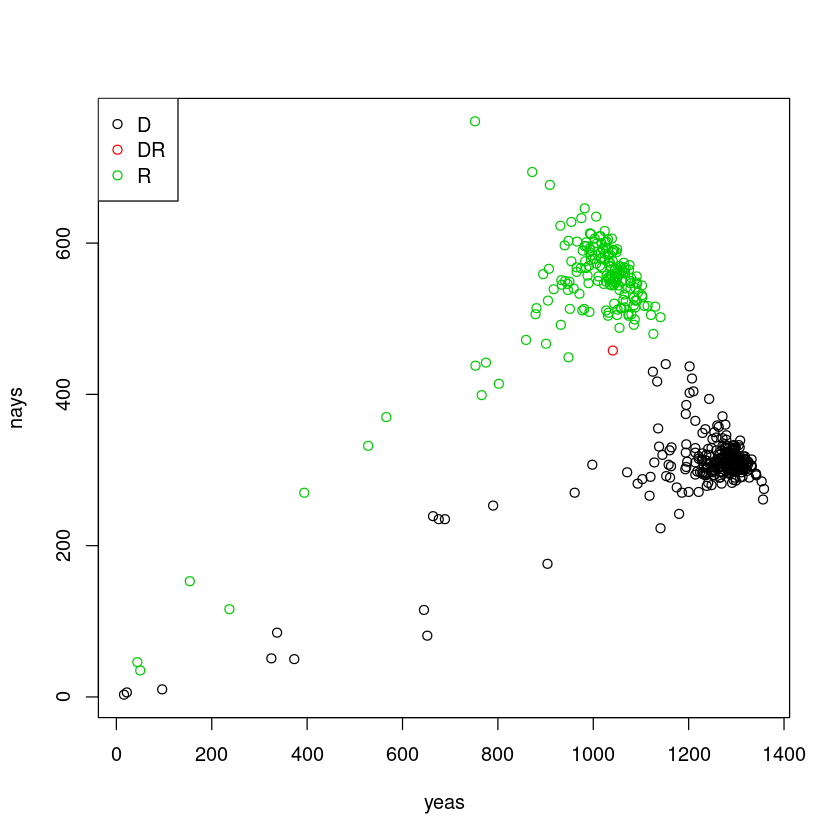

In [8]:
# Counts - yes and nos
yeas <- rowSums(votes[,(1:ncol(votes))]== 1)
nays <- rowSums(votes[,(1:ncol(votes))]== -1)

# Plots - Party
plot(yeas, nays, col = members$party)
legend('topleft', legend = levels(members$party), col = 1:3,  pch = 1)

# Principal Component Analysis (PCA)

**a) Run a principal component analysis on the votes data set. How many principal components are there?**

In [9]:
# PCA
pr.out = prcomp(votes , center = TRUE, scale = TRUE)

# No of principal components
dim(pr.out$rotation)[2]

[1] 445

**b) Calculate the proportion of variance explained by each principal component and plot the proportions for the ﬁrst 10 principal components.**

In [10]:
# variance explained by each component
pr.var = pr.out$sdev^2

# Proportion of variance explained
pve=pr.var/sum(pr.var)

# Print first 10 PC
pve[1:10]

[1] 0.363766111 0.129597633 0.033564738 0.025048759 0.011626388 0.011107666
 [7] 0.008850297 0.008244772 0.006765325 0.006487050

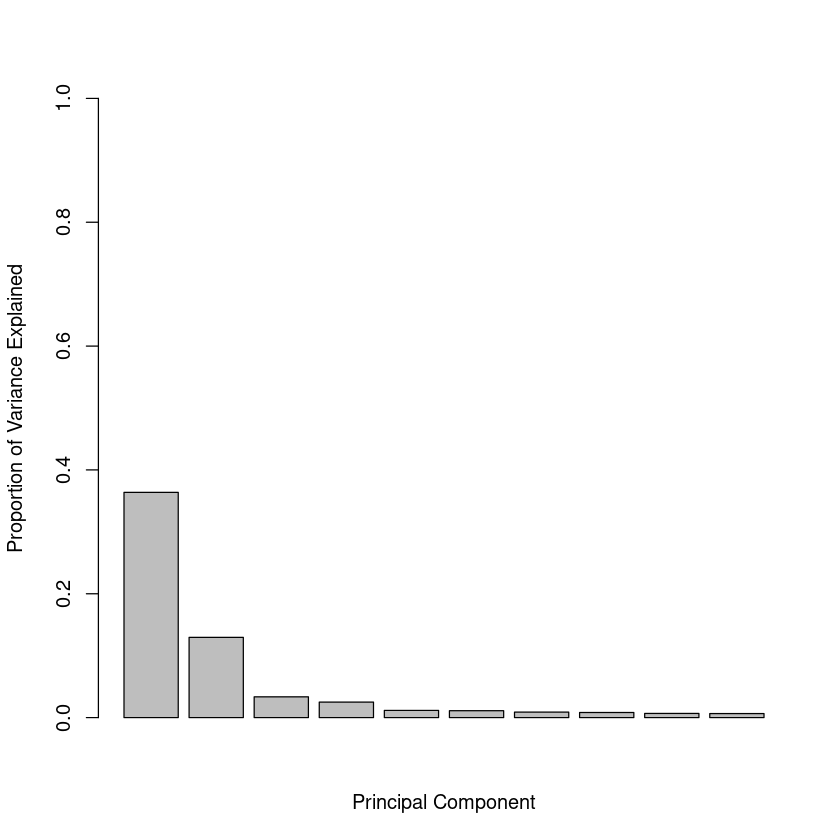

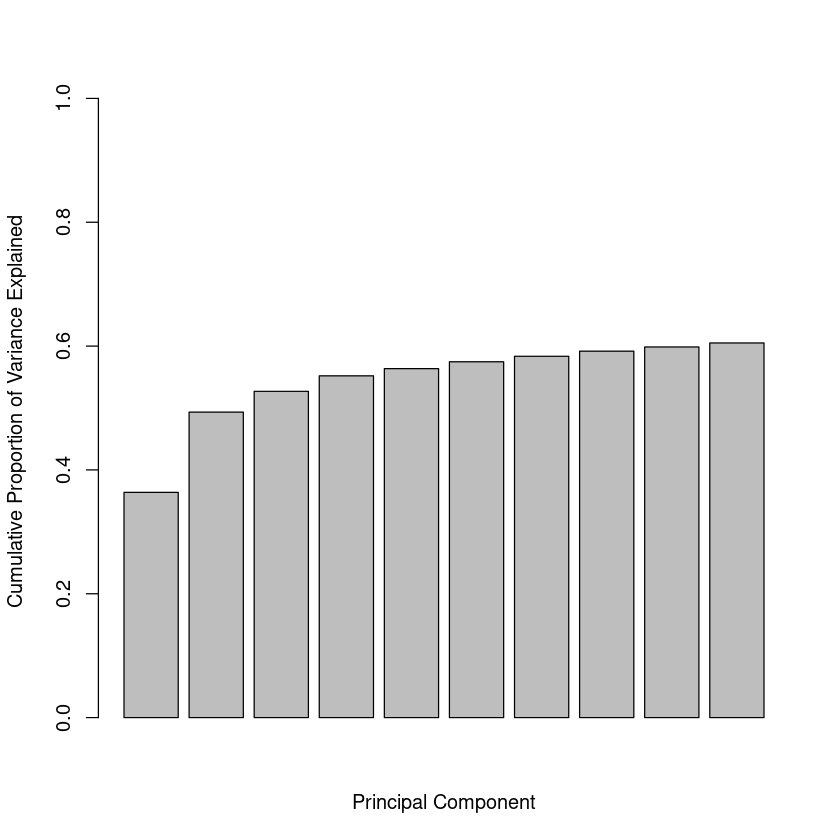

In [11]:
# Plot the first 10 PC
barplot(pve[1:10], xlab=" Principal Component ", ylab=" Proportion of Variance Explained ", ylim=c(0,1))
barplot(cumsum(pve[1:10]), xlab=" Principal Component ", ylab ="Cumulative Proportion of Variance Explained ", ylim=c(0,1))

**c) Plot the ﬁrst two principal components and use color to diﬀerentiate the observations by the party aﬃliation.**

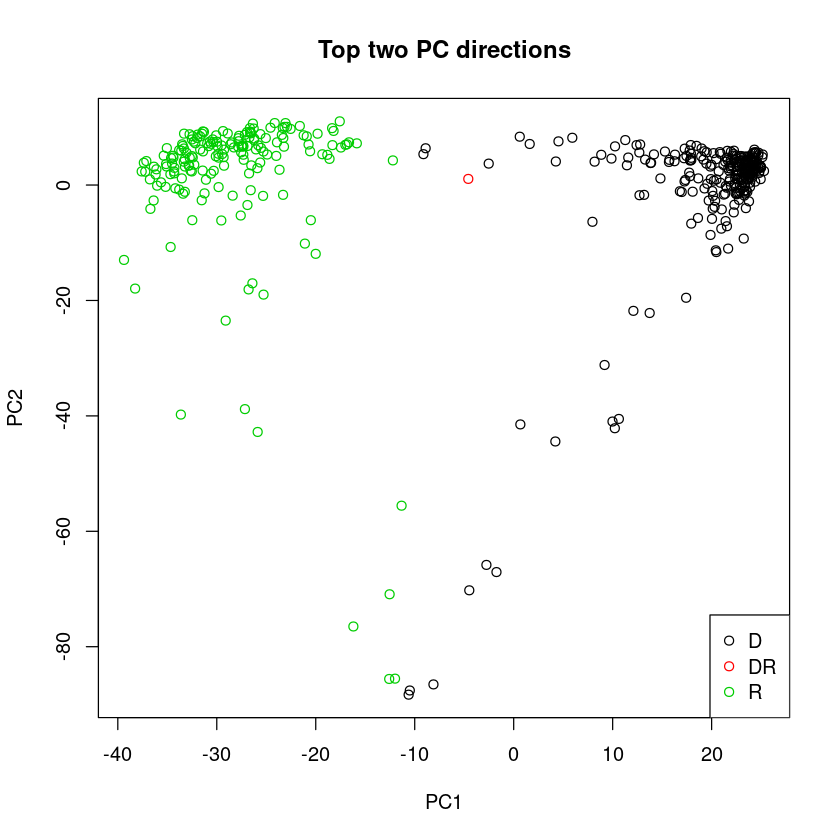

In [12]:
# Plot the first two principal components, color the party membership
plot(pr.out$x[,1], pr.out$x[,2], xlab = "PC1", ylab = "PC2", col = members$party, main = "Top two PC directions")
legend('bottomright', legend = levels(members$party), col = 1:3,  pch = 1)

**d) With the help of the ﬁrst principal component ﬁnd politicians on the far right (very conservative) and far left (very liberal).**

In [13]:
## Far right (very conservative)
head(sort(pr.out$x[,1]))

BROUN (R GA-10)     FLAKE (R AZ-6) HENSARLIN (R TX-5)   LAMBORN (R CO-5) 
         -39.37394          -38.25067          -37.58706          -37.37032 
   FRANKS (R AZ-2)      FOXX (R NC-5) 
         -37.22842          -37.11701

In [14]:
## Far left (very liberal)
head(sort(pr.out$x[,1], decreasing=TRUE))

EDWARDS (D MD-4)    PRICE (D NC-4)   MATSUI (D CA-5) SCHAKOWS (D IL-9) 
         25.29151          25.15912          25.12481          24.98754 
  HIRONO (D HI-2) SERRANO (D NY-16) 
         24.98547          24.97287

**e) Find the votings which have the most extreme loadings for the second principal component. Analyze the voting behavior in these votings and come up with the interpretation of the second component.**

In [15]:
# PC 2
head(sort(pr.out$x[,2]))
# No clear pattern based on party and state information

SOLIS (D CA-32) GILLIBRAND (D NY-20)      PELOSI (D CA-8) 
           -88.31351            -87.58872            -86.53586 
   STUTZMAN (R IN-3)       REED (R NY-29)      GRAVES (R GA-9) 
           -85.59217            -85.53636            -76.49658

In [16]:
# Look at the largest loadings in PC2 to discern an interpretation.
loadings <- pr.out$rotation
loadings[order(abs(loadings[,2]), decreasing=TRUE)[1:5],2]

Vote.1146   Vote.658  Vote.1090  Vote.1104  Vote.1149 
0.05605862 0.05461947 0.05300806 0.05168382 0.05155729

In [17]:
# Analyze voting behavior
table(votes[,1146])
table(votes[,658])
table(votes[,1090])


  0   1 
 16 429 


  0   1 
 13 432 


  0   1 
 22 423 

In [18]:
# Either everyone voted "yea" or missed the voting.
# These votes all correspond to near-unanimous symbolic action.

# Mystery Solved: the second PC is just attendance!
head(sort(rowSums(votes==0), decreasing=TRUE))

SOLIS (D CA-32) GILLIBRAND (D NY-20)       REED (R NY-29) 
                1628                 1619                 1562 
   STUTZMAN (R IN-3)      PELOSI (D CA-8)      GRAVES (R GA-9) 
                1557                 1541                 1340

<span style="color:red; font-weight:bold; font-size:xx-large;">
# Time for a breakout session 
</span>


# Clustering

**a) Run a k-means clustering procedure to detect 2 clusters in the data. How many Democrats and Republicans are in each cluster?**

In [23]:
set.seed(11122019)

# K-means clustering with 2 clusters
km.out = kmeans(votes, 2, nstart = 20)
#km.out$cluster
# Tabulate party vs cluster
table(members$party, km.out$cluster)


    
       1   2
  D  258   4
  DR   0   1
  R    0 182

In [24]:
km.out$cluster

BONNER (R AL-1)      BRIGHT (D AL-2)      ROGERS (R AL-3) 
                   2                    2                    2 
   ADERHOLT (R AL-4)  GRIFFITH (D/R AL-5)      BACHUS (R AL-6) 
                   2                    2                    2 
      DAVIS (D AL-7)       YOUNG (R AK-1) KIRKPATRICK (D AZ-1) 
                   1                    2                    1 
     FRANKS (R AZ-2)     SHADEGG (R AZ-3)      PASTOR (D AZ-4) 
                   2                    2                    1 
   MITCHELL (D AZ-5)       FLAKE (R AZ-6)    GRIJALVA (D AZ-7) 
                   1                    2                    1 
   GIFFORDS (D AZ-8)       BERRY (D AR-1)      SNYDER (D AR-2) 
                   1                    1                    1 
    BOOZMAN (R AR-3)        ROSS (D AR-4)    THOMPSON (D CA-1) 
                   2                    1                    1 
     HERGER (R CA-2)     LUNGREN (R CA-3)  MCCLINTOCK (R CA-4) 
                   2                    2                    2 
     MATSUI (D CA-5)     WOOLSEY (D CA-6)      MILLER (D CA-7) 
                   1                    1                    1 
     PELOSI (D CA-8)         LEE (D CA-9)   TAUSCHER (D CA-10) 
                   1                    1                    1 
 GARAMENDI (D CA-10)   MCNERNEY (D CA-11)     SPEIER (D CA-12) 
                   1                    1                    1 
     STARK (D CA-13)      ESHOO (D CA-14)      HONDA (D CA-15) 
                   1                    1                    1 
   LOFGREN (D CA-16)       FARR (D CA-17)    CARDOZA (D CA-18) 
                   1                    1                    1 
  RADANOVI (R CA-19)      COSTA (D CA-20)      NUNES (R CA-21) 
                   2                    1                    2 
  MCCARTHY (R CA-22)      CAPPS (D CA-23)   GALLEGLY (R CA-24) 
                   2                    1                    2 
    MCKEON (R CA-25)     DREIER (R CA-26)    SHERMAN (D CA-27) 
                   2                    2                    1 
    BERMAN (D CA-28)     SCHIFF (D CA-29)     WAXMAN (D CA-30) 
                   1                    1                    1 
   BECERRA (D CA-31)      SOLIS (D CA-32)        CHU (D CA-32) 
                   1                    2                    1 
    WATSON (D CA-33)   ROYBAL-A (D CA-34)     WATERS (D CA-35) 
                   1                    1                    1 
    HARMAN (D CA-36) RICHARDSON (D CA-37)   NAPOLITA (D CA-38) 
                   1                    1                    1 
   SANCHEZ (D CA-39)      ROYCE (R CA-40)      LEWIS (R CA-41) 
                   1                    2                    2 
    MILLER (R CA-42)       BACA (D CA-43)    CALVERT (R CA-44) 
                   2                    1                    2 
      BONO (R CA-45)   ROHRABAC (R CA-46)    SANCHEZ (D CA-47) 
                   2                    2                    1 
  CAMPBELL (R CA-48)       ISSA (R CA-49)    BILBRAY (R CA-50) 
                   2                    2                    2 
    FILNER (D CA-51)     HUNTER (R CA-52)      DAVIS (D CA-53) 
                   1                    2                    1 
    DEGETTE (D CO-1)       POLIS (D CO-2)     SALAZAR (D CO-3) 
                   1                    1                    1 
     MARKEY (D CO-4)     LAMBORN (R CO-5)     COFFMAN (R CO-6) 
                   1                    2                    2 
 PERLMUTTER (D CO-7)      LARSON (D CT-1)    COURTNEY (D CT-2) 
                   1                    1                    1 
    DELAURO (D CT-3)       HIMES (D CT-4)      MURPHY (D CT-5) 
                   1                    1                    1 
     CASTLE (R DE-1)      MILLER (R FL-1)        BOYD (D FL-2) 
                   2                    2                    1 
      BROWN (D FL-3)    CRENSHAW (R FL-4)   BROWN-WAI (R FL-5) 
                   1                    2                    2 
    STEARNS (R FL-6)        MICA (R F

**b) Run a k-means clustering procedure for k ∈{2,...,20} and plot the within cluster sum of squared errors. Decide based on the plot what the optimal number of clusters is.**

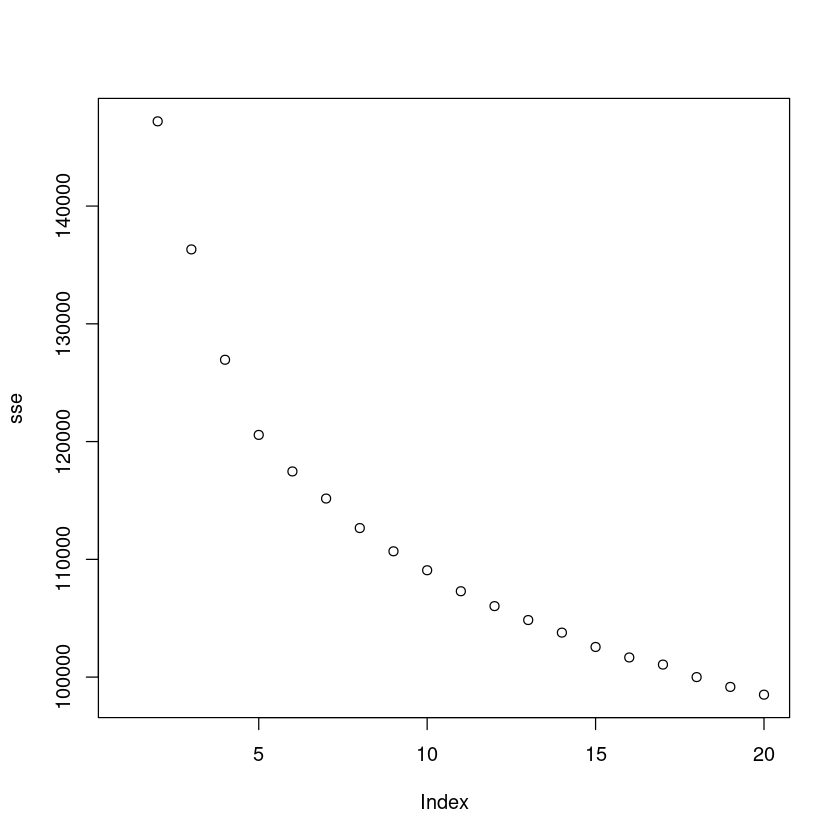

In [25]:
# How to analyze the optimal number of clusters

sse <- c()
sse[1] <- Inf

for (ind_cl in c(2:20)) {
  set.seed(3)
  km.out = kmeans (votes, ind_cl, nstart = 20)
  sse[ind_cl] = km.out$tot.withinss
}

plot(sse)
# Optimum 4-5 clusters

**c) Take the graph with two principal components and use color to visualize the clusters you found in the previous task.**

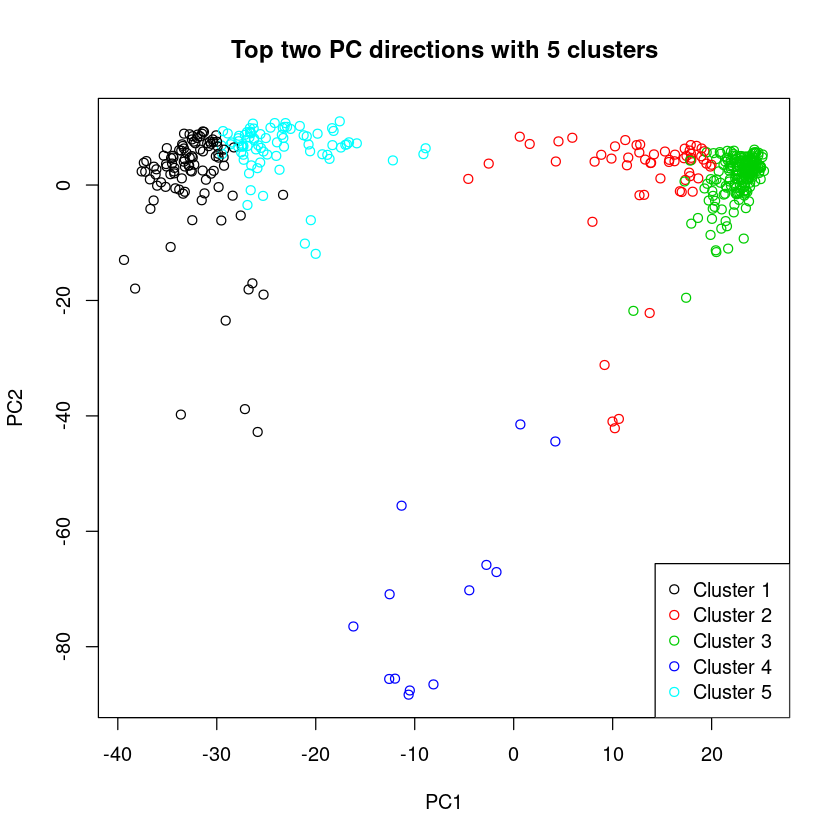

In [29]:
# Plot the 5 clusters on the PC components graph
set.seed(3)
km.out = kmeans (votes, 5, nstart = 20)

# Plot the first two principal components color the party membership
plot(pr.out$x[,1], pr.out$x[,2], xlab = "PC1", ylab = "PC2", col = km.out$cluster, main = "Top two PC directions with 5 clusters")
legend('bottomright', legend = c("Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"), col = 1:5,  pch = 1)

**d) Run a k-means clustering procedure to detect 6 clusters with nstart = 1 and nstart = 20. Print out the within cluster sum of squared errors for both nstart values. What can you say about the importance of nstart on the convergence to the global optimum?**

In [30]:
# Analyzing how the number of starts work
set.seed (3)
print('With nstart = 1')
km.out = kmeans (votes,6, nstart = 1)
km.out$tot.withinss

print('With nstart = 20')
km.out =kmeans (votes,6, nstart = 20)
km.out$tot.withinss

print('With nstart = 100')
km.out =kmeans (votes,6, nstart = 100)
km.out$tot.withinss

print('With nstart = 500')
km.out =kmeans (votes,6, nstart = 500)
km.out$tot.withinss


[1] "With nstart = 1"


[1] 124967.3

[1] "With nstart = 20"


[1] 117465.4

[1] "With nstart = 100"


[1] 117446.6

[1] "With nstart = 500"


[1] 117446.6

<span style="color:red; font-weight:bold; font-size:xx-large;">
# Time for a breakout session 
</span>
